## Test CNN

The objective of this notebook is test the usability of the processed data in a toy CNN

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import math
import json
import sys
import seaborn as sns

In [2]:
# Make tf to ignore GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

#restrict GPU mem
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)

try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('GPU Memory limited!')
except:
    print('It was not possible to limit GPU memory')

[]
It was not possible to limit GPU memory


In [3]:
# Load dataset
local_tf_datasets="/home/hhughes/Documents/Master_Thesis/Project/datasets/tensorflow_datasets"
dataset, metadata = tfds.load(
    'MPP_dataset', 
    data_dir=local_tf_datasets, 
    # If False, returns a dictionary with all the features
    as_supervised=False, 
    shuffle_files=False,
    with_info=True)

# Load the splits
train_data, val_data, test_data = dataset['train'], dataset['validation'], dataset['test']

In [4]:
metadata

tfds.core.DatasetInfo(
    name='mpp_dataset',
    version=1.0.0,
    description='Dataset containing images of Multiplexed protein maps.
The elements of this data sets are multichannel images of singel cells alongside with its transcription rate.
This Dataset was builded after a preprocessing using the python script Transform_MPPData_into_images_from_script.ipynb. During this preprocessing the original MPPData was:
- Converted into images.
- Cleaned. Border and mitotic cells were removed.
- Normalized. Each channel was normalized using scale parameters obtained from the training set.
- Target value (scalar) calculated. The transcription rate was approximated taking the average of the measured pixels of the channel 00_EU. It is important to mention that the the target value was calculated BEFORE the normalization process.

input_channels:
['00_DAPI', '07_H2B', '01_CDK9_pT186', '03_CDK9', '05_GTF2B', '07_SETD1A', '08_H3K4me3', '09_SRRM2', '10_H3K27ac', '11_KPNA2_MAX', '12_RB1_pS807_S811

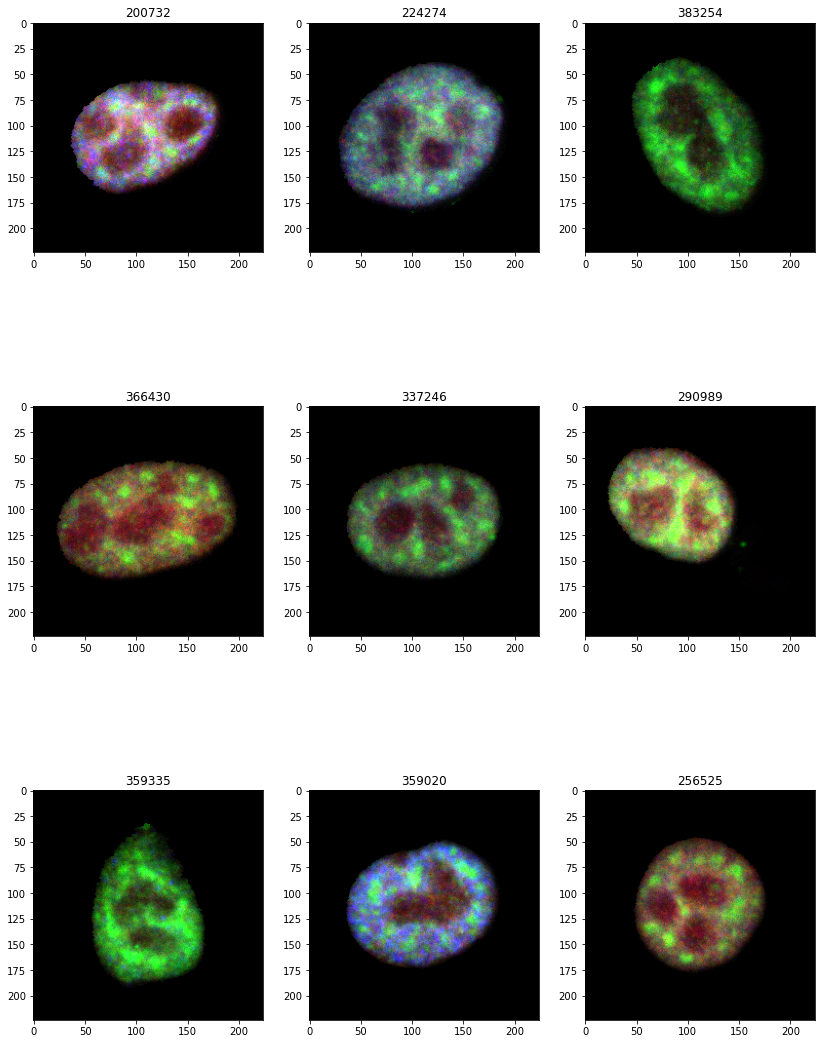

In [5]:
# Take a look into some of the images
plt.figure(figsize=(14,20))
for i, cell in enumerate(train_data.take(9), 1):
    plt.subplot(3, 3, i)
    img = cell['image']
    cell_id = cell['mapobject_id_cell'].numpy().decode()
    plt.imshow(img.numpy()[:,:,10:13],
               cmap=plt.cm.PiYG,
               vmin=0, vmax=1)
    plt.title(cell_id)
plt.show()

Model:

In [6]:
img_shape = metadata.features['image'].shape

# Fit model
#history = model.fit(train_data, 
#          validation_data=val_data,
#          epochs=15, 
#          steps_per_epoch=math.ceil(n_train/BATCH_SIZE))

# Load the model
model_path = '/home/hhughes/Documents/Master_Thesis/Project/workspace/models'
#model.save(os.path.join(model_path, 'model_3'))
model = tf.keras.models.load_model(os.path.join(model_path, 'model_3'))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      21376     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 401408)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               102760704 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2

In [37]:
# The first time you use the dataset the images will be loaded form disk
# Caching will keep them in memory, making training faster
#train_data = train_data.cache()
#val_data = val_data.cache()

# Prepare data
BATCH_SIZE = 32
n_train = metadata.splits['train'].num_examples
train_data = train_data.cache().repeat().shuffle(n_train).batch(BATCH_SIZE)
val_data = val_data.cache().batch(BATCH_SIZE)
#train_data = train_data.repeat().shuffle(n_train).batch(BATCH_SIZE)
#val_data = val_data.batch(BATCH_SIZE)

In [19]:
# Evaluate test model
#test_predictions = model.predict(test_data).flatten()

m_shape = tuple([1]+list(img_shape))

y_test = []
y_test_hat = []
cell_ids = []
for cell in test_data:
    cell_img = cell['image']
    cell_id = cell['mapobject_id_cell'].numpy().decode()
    cell_y = cell['target']
    y_test.append(cell_y.numpy()[0])
    y_test_hat.append(model.predict(tf.reshape(cell_img, m_shape))[0][0])
    cell_ids.append(cell_id)

y_test = np.asarray(y_test).reshape((-1,1))
y_test_hat = np.asarray(y_test_hat).reshape((-1,1))
cell_ids = np.asarray(cell_ids).reshape((-1,1))

In [100]:
temp = np.concatenate((y_test, y_test_hat, y_test-y_test_hat, abs(y_test-y_test_hat)), axis=1)

temp_df = pd.DataFrame(temp, columns=['y_test', 'y_test_hat', 'diff', 'abs_diff'])
temp_df['cel_id'] = cell_ids
temp_df.sort_values(by=['abs_diff'], ascending=False)

y_test  y_test_hat        diff    abs_diff  cel_id
96   504.980560  344.201508  160.779053  160.779053  359343
60   313.383636  454.792938 -141.409302  141.409302  366411
76   476.624359  368.597107  108.027252  108.027252  324750
39   477.175354  379.533600   97.641754   97.641754  231513
7    397.334961  492.577362  -95.242401   95.242401  366415
..          ...         ...         ...         ...     ...
5    359.091522  356.515564    2.575958    2.575958  276484
26   333.570740  335.553772   -1.983032    1.983032  280735
53   355.674194  354.043488    1.630707    1.630707  220483
66   357.582489  359.091858   -1.509369    1.509369  281005
120  368.984222  367.623230    1.360992    1.360992  257711

[123 rows x 5 columns]

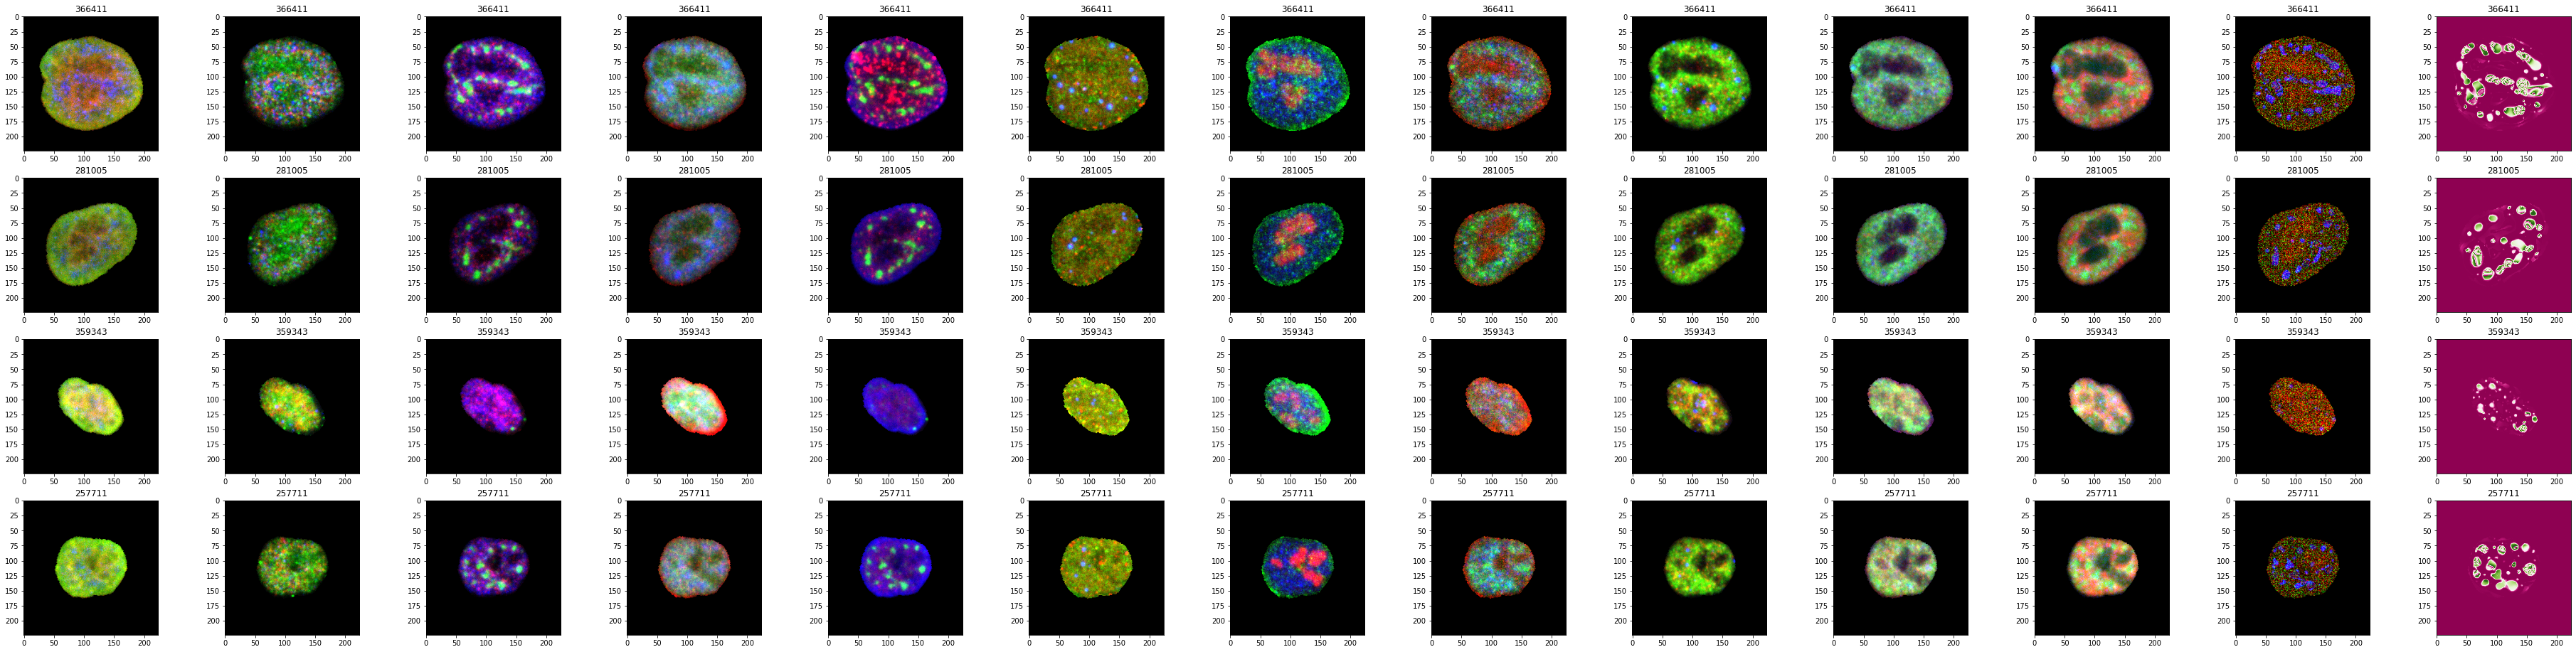

In [103]:
plot_ids=['359343', '366411', '257711', '281005']
n_cells = len(plot_ids)
n_channels = m_shape[-1]
n_plots = math.ceil(n_channels / 3)

plt.figure(figsize=(n_plots*5,n_cells*4))

n_cell = 0
for cell in test_data:
    img = cell['image']
    cell_id = cell['mapobject_id_cell'].numpy().decode()
    if cell_id in plot_ids:
        l_idx=0
        h_idx=0
        for cs in range(n_plots):
            l_idx = cs*3
            h_idx = (cs+1)*3
            if h_idx>n_channels: h_idx=n_channels
                
            plt.subplot(n_cells, n_plots,n_cell*n_plots + cs+1)
            plt.imshow(img.numpy()[:,:,l_idx:h_idx],
                       cmap=plt.cm.PiYG,
                       vmin=0, vmax=1)
            plt.title(cell_id)
        n_cell += 1
plt.show()

In [133]:
temp_df.sort_values(by=['diff'], ascending=False).reset_index()

index      y_test  y_test_hat        diff    abs_diff  cel_id
0       96  504.980560  344.201508  160.779053  160.779053  359343
1       76  476.624359  368.597107  108.027252  108.027252  324750
2       39  477.175354  379.533600   97.641754   97.641754  231513
3      114  443.565460  354.932892   88.632568   88.632568  290975
4       80  384.637451  306.103729   78.533722   78.533722  378133
..     ...         ...         ...         ...         ...     ...
118     32  324.310883  400.111481  -75.800598   75.800598  331807
119     20  334.367676  410.448914  -76.081238   76.081238  334458
120     29  355.530731  442.684967  -87.154236   87.154236  205743
121      7  397.334961  492.577362  -95.242401   95.242401  366415
122     60  313.383636  454.792938 -141.409302  141.409302  366411

[123 rows x 6 columns]

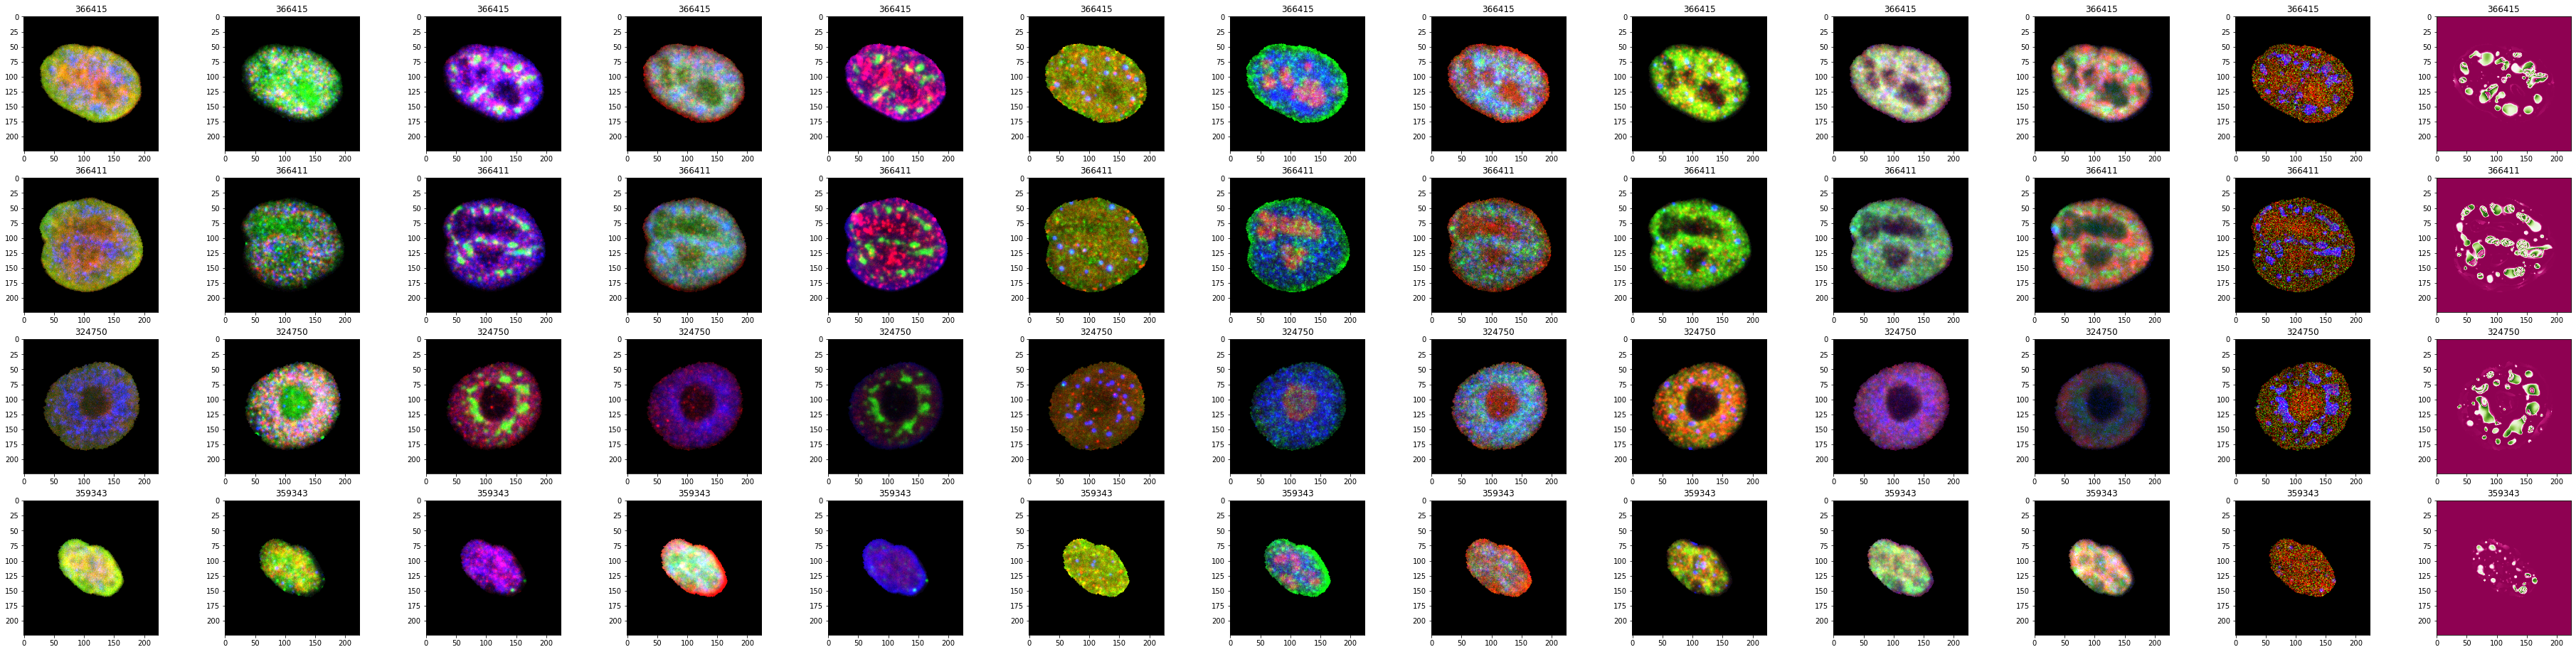

In [134]:
plot_ids=['359343', '324750', '366415', '366411']
n_cells = len(plot_ids)
n_channels = m_shape[-1]
n_plots = math.ceil(n_channels / 3)

plt.figure(figsize=(n_plots*5,n_cells*4))

n_cell = 0
for cell in test_data:
    img = cell['image']
    cell_id = cell['mapobject_id_cell'].numpy().decode()
    if cell_id in plot_ids:
        l_idx=0
        h_idx=0
        for cs in range(n_plots):
            l_idx = cs*3
            h_idx = (cs+1)*3
            if h_idx>n_channels: h_idx=n_channels
                
            plt.subplot(n_cells, n_plots,n_cell*n_plots + cs+1)
            plt.imshow(img.numpy()[:,:,l_idx:h_idx],
                       cmap=plt.cm.PiYG,
                       vmin=0, vmax=1)
            plt.title(cell_id)
        n_cell += 1
plt.show()

In [130]:
metadata_path = '/home/hhughes/Documents/Master_Thesis/Project/datasets/184A1_hannah_imgs_scalars_test/metadata.csv'
metadata_cells = pd.read_csv(metadata_path)
mask = ((metadata_cells.mapobject_id_cell == 359343) | (metadata_cells.mapobject_id_cell == 324750))
metadata_cells[mask]

Unnamed: 0  mapobject_id plate_name well_name  well_pos_y  well_pos_x  \
1113        1113        359388    plate01       I09           3           1   
1172        1172        324809    plate01       I11           2           1   

      tpoint  zplane  label  is_border  mapobject_id_cell plate_name_cell  \
1113       0       0     29          0             359343         plate01   
1172       0       0     10          0             324750         plate01   

     well_name_cell  well_pos_y_cell  well_pos_x_cell  tpoint_cell  \
1113            I09                3                1            0   
1172            I11                2                1            0   

      zplane_cell  label_cell  is_border_cell  is_mitotic  is_mitotic_labels  \
1113            0          29               0         0.0                NaN   
1172            0          10               0         0.0                NaN   

      is_polynuclei_HeLa  is_polynuclei_HeLa_labels  is_polynuclei_184A1  \
1113                 0.0                        NaN                  0.0   
1172                 0.0                        NaN                  0.0   

      is_polynuclei_184A1_labels cell_cycle cell_type perturbation  duration  \
1113                         NaN         G1     184A1       normal       NaN   
1172                         NaN         G1     184A1       normal       NaN   

      00_DAPI_avg  07_H2B_avg  01_CDK9_pT186_avg  03_CDK9_avg  05_GTF2B_avg  \
1113     0.909728    0.881551           0.607416     0.874910       0.86191   
1172     0.364193    0.274611           0.758906     1.017439       0.74525   

      07_SETD1A_avg  08_H3K4me3_avg  09_SRRM2_avg  10_H3K27ac_avg  \
1113       0.285168        0.753027      0.178558        0.866296   
1172       0.857510        0.614047      0.799598        0.272586   

      11_KPNA2_MAX_avg  12_RB1_pS807_S811_avg  13_PABPN1_avg  14_PCNA_avg  \
1113          0.988331               0.891134       0.994097     0.352244   
1172          0.298002               0.022823       0.635684     0.195519   

      15_SON_avg  16_H3_avg  17_HDAC3_avg  19_KPNA1_MAX_avg  20_SP100_avg  \
1113    0.260338   0.745206      0.743516          0.762667      0.302419   
1172    0.550693   0.145152      0.432240          0.222515      0.714804   

      21_NCL_avg  01_PABPC1_avg  02_CDK7_avg  03_RPS6_avg  05_Sm_avg  \
1113    0.845430       0.937721     0.680792     0.949155   0.632384   
1172    0.392337       0.329683     0.701281     0.558108   0.642097   

      07_POLR2A_avg  09_CCNT1_avg  10_POL2RA_pS2_avg  11_PML_avg  12_YAP1_avg  \
1113       0.552010      0.782512           0.778140    0.731003     0.694217   
1172       0.855718      0.862192           0.538693    0.785612     0.507246   

      13_POL2RA_pS5_avg  15_U2SNRNPB_avg  18_NONO_avg  20_ALYREF_avg  \
1113           0.899621         0.684699     1.053767       0.882980   
1172           0.236034         0.765414     0.274723       0.233963   

      21_COIL_avg  00_BG488_avg  00_BG568_avg  00_EU_avg  \
1113     0.951715      1.002379      0.921425   0.994813   
1172     0.471290      0.705728      0.886444   0.938951   

      09_SRRM2_ILASTIK_avg  15_SON_ILASTIK_avg   set  
1113              0.148184            0.378864  test  
1172              0.967336            0.723885  test

In [132]:
metadata_path = '/home/hhughes/Documents/Master_Thesis/Project/datasets/184A1_hannah_imgs_scalars_test/metadata.csv'
metadata_cells = pd.read_csv(metadata_path)
mask = ((metadata_cells.mapobject_id_cell == 257711) | (metadata_cells.mapobject_id_cell == 281005))
metadata_cells[mask]

Unnamed: 0  mapobject_id plate_name well_name  well_pos_y  well_pos_x  \
1138        1138        281055    plate01       I09           5           3   
1197        1197        257749    plate01       I11           5           0   

      tpoint  zplane  label  is_border  mapobject_id_cell plate_name_cell  \
1138       0       0     11          0             281005         plate01   
1197       0       0     31          0             257711         plate01   

     well_name_cell  well_pos_y_cell  well_pos_x_cell  tpoint_cell  \
1138            I09                5                3            0   
1197            I11                5                0            0   

      zplane_cell  label_cell  is_border_cell  is_mitotic  is_mitotic_labels  \
1138            0          11               0         0.0                NaN   
1197            0          31               0         0.0                NaN   

      is_polynuclei_HeLa  is_polynuclei_HeLa_labels  is_polynuclei_184A1  \
1138                 0.0                        NaN                  0.0   
1197                 0.0                        NaN                  0.0   

      is_polynuclei_184A1_labels cell_cycle cell_type perturbation  duration  \
1138                         NaN         G1     184A1       normal       NaN   
1197                         NaN         G1     184A1       normal       NaN   

      00_DAPI_avg  07_H2B_avg  01_CDK9_pT186_avg  03_CDK9_avg  05_GTF2B_avg  \
1138     0.491525    0.531361           0.355665     0.358219      0.563635   
1197     0.655841    0.809441           0.383296     0.556268      0.660054   

      07_SETD1A_avg  08_H3K4me3_avg  09_SRRM2_avg  10_H3K27ac_avg  \
1138       0.304767        0.314236      0.459970        0.301598   
1197       0.247277        0.454008      0.681689        0.581620   

      11_KPNA2_MAX_avg  12_RB1_pS807_S811_avg  13_PABPN1_avg  14_PCNA_avg  \
1138           0.29485               0.326122       0.589933     0.308943   
1197           0.52315               0.562322       0.729812     0.350895   

      15_SON_avg  16_H3_avg  17_HDAC3_avg  19_KPNA1_MAX_avg  20_SP100_avg  \
1138    0.490670   0.439502      0.445409          0.405507      0.313117   
1197    0.616035   0.734238      0.604885          0.618698      0.303328   

      21_NCL_avg  01_PABPC1_avg  02_CDK7_avg  03_RPS6_avg  05_Sm_avg  \
1138    0.539395       0.433318     0.454142     0.484236   0.599302   
1197    0.849560       0.350873     0.587245     0.550391   0.709377   

      07_POLR2A_avg  09_CCNT1_avg  10_POL2RA_pS2_avg  11_PML_avg  12_YAP1_avg  \
1138       0.308802      0.437011           0.717063    0.327401     0.355736   
1197       0.622521      0.538177           0.870289    0.324338     0.632858   

      13_POL2RA_pS5_avg  15_U2SNRNPB_avg  18_NONO_avg  20_ALYREF_avg  \
1138           0.650693         0.525938     0.612644       0.599247   
1197           0.798573         0.598012     0.944833       0.826648   

      21_COIL_avg  00_BG488_avg  00_BG568_avg  00_EU_avg  \
1138     0.482521      0.639241      0.887613   0.704439   
1197     0.721615      0.575498      0.841816   0.726900   

      09_SRRM2_ILASTIK_avg  15_SON_ILASTIK_avg   set  
1138              0.499423            0.631321  test  
1197              0.691205            0.783353  test

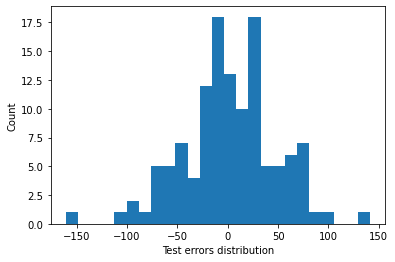

In [43]:
# Plot test data errors
plt.hist(y_test_hat - y_test, bins=25)
plt.xlabel('Test errors distribution')
_ = plt.ylabel('Count')

<AxesSubplot:xlabel='abs_diff', ylabel='Density'>

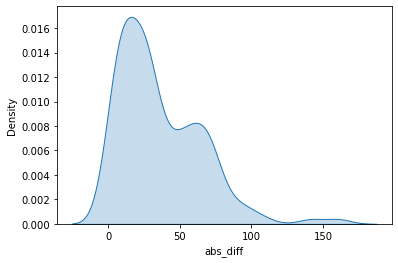

In [50]:
sns.kdeplot(x='abs_diff',
            shade=True,
            bw_method=0.3,
            data=temp_df)

<AxesSubplot:xlabel='var', ylabel='values'>

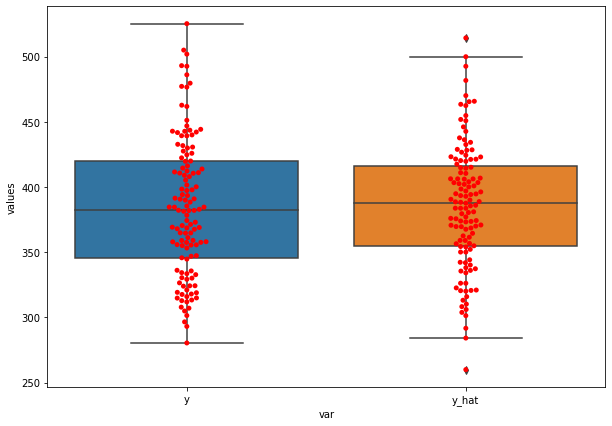

In [51]:
y_df = pd.DataFrame(y_test.reshape((-1,1)), columns=['values'])
y_df['var'] = 'y'
y_hat_df = pd.DataFrame(y_test_hat.reshape((-1,1)), columns=['values'])
y_hat_df['var'] = 'y_hat'
temp = pd.concat((y_df, y_hat_df), axis=0).reset_index()

plt.figure(figsize=(10,7))

sns.boxplot(y='values',
            x='var',
            data=temp)

sns.swarmplot(y='values',
              x='var',
              color='red',
              data=temp)